In [227]:
import math
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import networkx as nx

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from mlxtend.frequent_patterns import apriori, association_rules, fpgrowth
from mlxtend.preprocessing import TransactionEncoder
from itertools import combinations

df = pd.read_csv("TV_Shows.csv")
print("Размер данных")
print(df.shape)
print("Информация")
print(df.info())

Размер данных
(9689, 32)
Информация
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9689 entries, 0 to 9688
Data columns (total 32 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Cobra Kai    9689 non-null   object
 1   Lupin        7556 non-null   object
 2   12 Monkeys   5946 non-null   object
 3   Sherlock     4666 non-null   object
 4   Unnamed: 4   3678 non-null   object
 5   Unnamed: 5   2837 non-null   object
 6   Unnamed: 6   2197 non-null   object
 7   Unnamed: 7   1664 non-null   object
 8   Unnamed: 8   1231 non-null   object
 9   Unnamed: 9   887 non-null    object
 10  Unnamed: 10  644 non-null    object
 11  Unnamed: 11  464 non-null    object
 12  Unnamed: 12  348 non-null    object
 13  Unnamed: 13  272 non-null    object
 14  Unnamed: 14  196 non-null    object
 15  Unnamed: 15  141 non-null    object
 16  Unnamed: 16  95 non-null     object
 17  Unnamed: 17  66 non-null     object
 18  Unnamed: 18  52 non-null     obj

In [228]:
print("Строки")
print(df.head(5))

Строки
       Cobra Kai          Lupin   12 Monkeys          Sherlock  \
0           Lost      Jack Ryan    The Flash   Game of thrones   
1  Sex Education      Dr. House      Kingdom  The Walking Dead   
2          Ozark  Sex Education  Constantine          Preacher   
3         Naruto            NaN          NaN               NaN   
4  Sex Education            NaN          NaN               NaN   

       Unnamed: 4  Unnamed: 5 Unnamed: 6 Unnamed: 7     Unnamed: 8  \
0  House of Cards  12 Monkeys    Vikings     Fringe  The Mentalist   
1             NaN         NaN        NaN        NaN            NaN   
2         Vikings    The Tick        NaN        NaN            NaN   
3             NaN         NaN        NaN        NaN            NaN   
4             NaN         NaN        NaN        NaN            NaN   

     Unnamed: 9  ... Unnamed: 22 Unnamed: 23 Unnamed: 24 Unnamed: 25  \
0  The Alienist  ...         NaN         NaN         NaN         NaN   
1           NaN  ...         Na

In [229]:
transaction_lengths = df.notna().sum(axis=1)

df['transaction_length'] = transaction_lengths

print(transaction_lengths.describe())

count    9689.000000
mean        4.414078
std         3.597709
min         1.000000
25%         2.000000
50%         3.000000
75%         6.000000
max        32.000000
dtype: float64


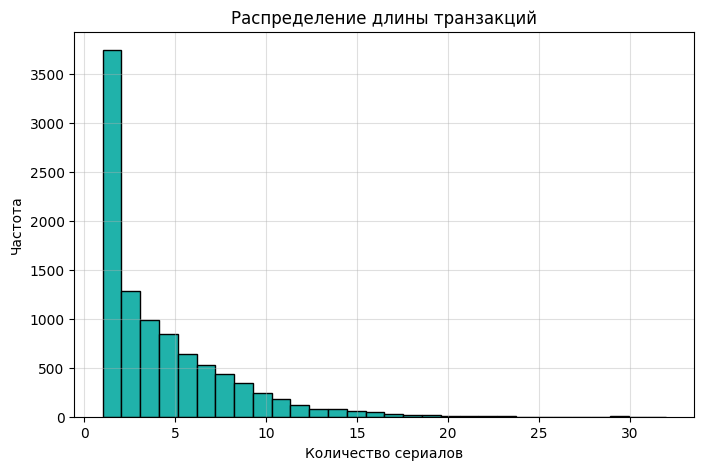

По распределению видно, что в транзакции чаще всего от 1 до 4 сериалов


In [230]:
plt.figure(figsize=(8,5))
plt.hist(transaction_lengths, bins=30, color='lightseagreen', edgecolor='black')
plt.title('Распределение длины транзакций')
plt.xlabel('Количество сериалов')
plt.ylabel('Частота')
plt.grid(alpha=0.4)
plt.show()
print("По распределению видно, что в транзакции чаще всего от 1 до 4 сериалов")

In [231]:
all_items = pd.Series(df.drop(columns='transaction_length').values.ravel()).dropna()

unique_items = sorted(all_items.unique())

print(f"Всего уникальных сериалов: {len(unique_items)}")
print(unique_items[:30]) 

Всего уникальных сериалов: 156
['12 Monkeys', '24', 'Absentia', 'Alice in Borderland', 'Altered Carbon', 'American Gods', 'Another Life', 'Archer', 'Arrow', 'Atypical', 'Banshee', 'Berlin Station', 'Better Call Saul', 'Big Little Lies', 'Billions', 'Black Clover', 'Bojack Horseman', 'Breaking Bad', 'Brooklyn Nine Nine', 'Chernobyl', 'Cobra Kai', 'Constantine', 'Daredevil', 'Dark', 'Death Note', 'Deception', 'Demon Slayer', 'Designated Survivor', 'Dexter', 'Doctor Who']


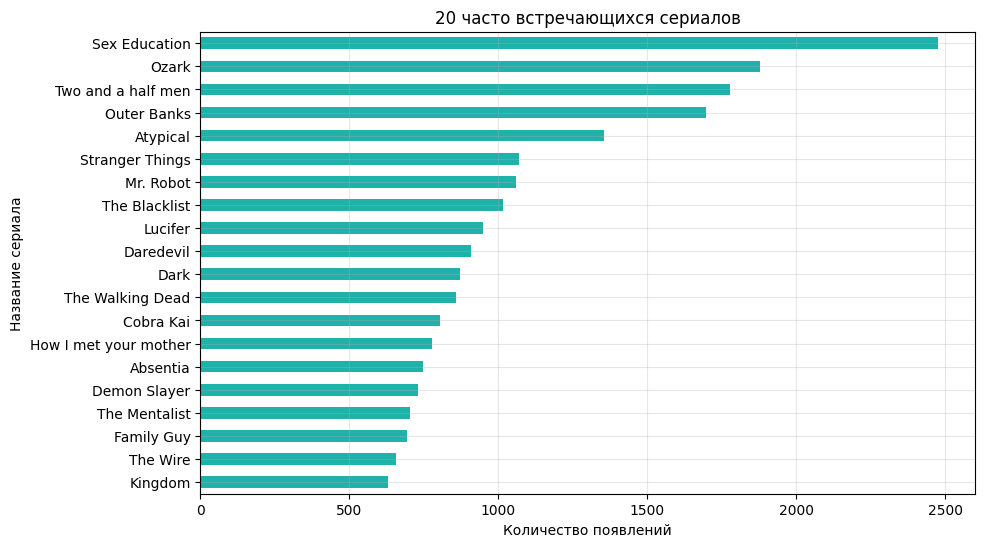

In [232]:
top_items = all_items.value_counts().head(20)

plt.figure(figsize=(10,6))
top_items.plot(kind='barh', color='lightseagreen')
plt.title('20 часто встречающихся сериалов')
plt.xlabel('Количество появлений')
plt.ylabel('Название сериала')
plt.gca().invert_yaxis()
plt.grid(alpha=0.3)
plt.show()

In [233]:
print("Пропущенные значения по столбцам:")
print(df.isna().sum())

Пропущенные значения по столбцам:
Cobra Kai                0
Lupin                 2133
12 Monkeys            3743
Sherlock              5023
Unnamed: 4            6011
Unnamed: 5            6852
Unnamed: 6            7492
Unnamed: 7            8025
Unnamed: 8            8458
Unnamed: 9            8802
Unnamed: 10           9045
Unnamed: 11           9225
Unnamed: 12           9341
Unnamed: 13           9417
Unnamed: 14           9493
Unnamed: 15           9548
Unnamed: 16           9594
Unnamed: 17           9623
Unnamed: 18           9637
Unnamed: 19           9651
Unnamed: 20           9660
Unnamed: 21           9671
Unnamed: 22           9675
Unnamed: 23           9681
Unnamed: 24           9682
Unnamed: 25           9682
Unnamed: 26           9683
Unnamed: 27           9684
Unnamed: 28           9685
Unnamed: 29           9688
Unnamed: 30           9688
Unnamed: 31           9688
transaction_length       0
dtype: int64


In [234]:
transactions = []
for i in range(len(df)):
    row = df.iloc[i, :-1].dropna().tolist()  
    transactions.append(row)

print("Первые 5 транзакций:", transactions[:5])
print("Число транзакций:", len(transactions))



Первые 5 транзакций: [['Lost', 'Jack Ryan', 'The Flash', 'Game of thrones', 'House of Cards', '12 Monkeys', 'Vikings', 'Fringe', 'The Mentalist', 'The Alienist', 'Big Little Lies', 'Chernobyl'], ['Sex Education', 'Dr. House', 'Kingdom', 'The Walking Dead'], ['Ozark', 'Sex Education', 'Constantine', 'Preacher', 'Vikings', 'The Tick'], ['Naruto'], ['Sex Education']]
Число транзакций: 9689



Анализ длин транзакций (коллекций сериалов):
Распределение количества сериалов в коллекциях:
 1 сериалов: 2133 пользователей ( 22.0%)
 2 сериалов: 1610 пользователей ( 16.6%)
 3 сериалов: 1280 пользователей ( 13.2%)
 4 сериалов:  988 пользователей ( 10.2%)
 5 сериалов:  841 пользователей (  8.7%)
 6 сериалов:  640 пользователей (  6.6%)
 7 сериалов:  533 пользователей (  5.5%)
 8 сериалов:  433 пользователей (  4.5%)
 9 сериалов:  344 пользователей (  3.6%)
10 сериалов:  243 пользователей (  2.5%)
11 сериалов:  180 пользователей (  1.9%)
12 сериалов:  116 пользователей (  1.2%)
13 сериалов:   76 пользователей (  0.8%)
14 сериалов:   76 пользователей (  0.8%)
15 сериалов:   55 пользователей (  0.6%)


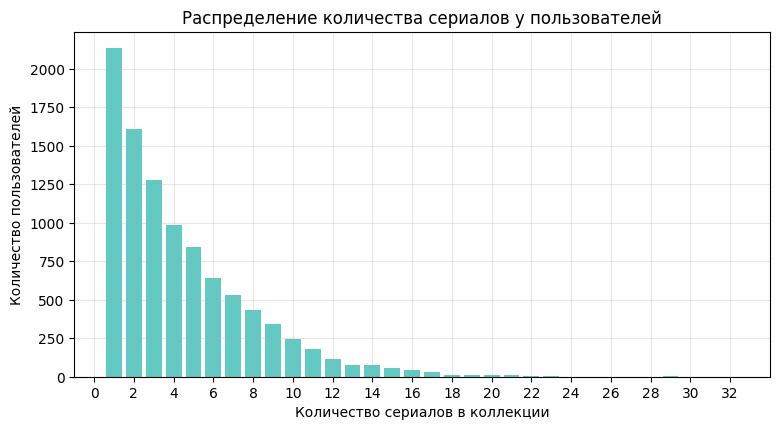


АНАЛИЗ БОЛЬШИХ КОЛЛЕКЦИЙ (≥20 сериалов):
Пользователей с ≥20 сериалов: 38 (0.4%)
Пользователей с ≥25 сериалов: 7
Максимальная коллекция: 32 сериалов

ПРИМЕРЫ БОЛЬШИХ КОЛЛЕКЦИЙ:
Коллекция 1 (20 сериалов): ['Daredevil', 'The Stranger', 'Demon Slayer', 'The Boys', 'Rick And Morty', 'Mr. Robot', 'Succession', 'Ozark', 'Sex Education', 'Berlin Station']...
Коллекция 2 (20 сериалов): ['Hanna', 'Into the night', 'The Blacklist', 'The Boys', 'Mr. Robot', 'Ozark', 'Sex Education', 'Deception', 'Doctor Who', 'The man in the high castle']...
Коллекция 3 (23 сериалов): ['Daredevil', 'The Stranger', 'Succession', 'Ozark', 'Better Call Saul', 'Berlin Station', 'Atypical', 'Emily in Paris', 'The Flash', 'Deception']...


In [235]:
print(f"\nАнализ длин транзакций (коллекций сериалов):")
length_counts = pd.Series(transaction_lengths).value_counts().sort_index()
print("Распределение количества сериалов в коллекциях:")
for length, count in length_counts.head(15).items():
    percentage = (count / len(transactions)) * 100
    print(f"{length:2} сериалов: {count:4} пользователей ({percentage:5.1f}%)")

plt.figure(figsize=(15, 8))

plt.subplot(2, 2, 1)
plt.bar(length_counts.index, length_counts.values, alpha=0.7, color='lightseagreen')
plt.xlabel('Количество сериалов в коллекции')
plt.ylabel('Количество пользователей')
plt.title('Распределение количества сериалов у пользователей')
plt.xticks(range(0, 33, 2))
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

large_transactions = [t for t in transactions if len(t) >= 20]
print(f"\nАНАЛИЗ БОЛЬШИХ КОЛЛЕКЦИЙ (≥20 сериалов):")
print(f"Пользователей с ≥20 сериалов: {len(large_transactions)} ({len(large_transactions)/len(transactions)*100:.1f}%)")
print(f"Пользователей с ≥25 сериалов: {len([t for t in transactions if len(t) >= 25])}")
print(f"Максимальная коллекция: {max(transaction_lengths)} сериалов")

if large_transactions:
    print("\nПРИМЕРЫ БОЛЬШИХ КОЛЛЕКЦИЙ:")
    for i, transaction in enumerate(large_transactions[:3]):
        print(f"Коллекция {i+1} ({len(transaction)} сериалов): {transaction[:10]}...")

In [236]:
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df_encoded = pd.DataFrame(te_ary, columns=te.columns_)

print(f"Размер закодированной матрицы: {df_encoded.shape}")
print(f"Количество товаров: {len(te.columns_)}")
print("\nПример закодированных данных (первые 10 товаров):")
print(df_encoded.iloc[:, :10].head())

Размер закодированной матрицы: (9689, 156)
Количество товаров: 156

Пример закодированных данных (первые 10 товаров):
   12 Monkeys     24  Absentia  Alice in Borderland  Altered Carbon  \
0        True  False     False                False           False   
1       False  False     False                False           False   
2       False  False     False                False           False   
3       False  False     False                False           False   
4       False  False     False                False           False   

   American Gods  Another Life  Archer  Arrow  Atypical  
0          False         False   False  False     False  
1          False         False   False  False     False  
2          False         False   False  False     False  
3          False         False   False  False     False  
4          False         False   False  False     False  


In [237]:
#3


frequent_itemsets = apriori(df_encoded, min_support=0.01, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.3)
rules_sorted = rules.sort_values(by='lift', ascending=False).reset_index(drop=True)

print("Apriori выявил 347 частых наборо и 128 правил")

print("")
print(f"Частые наборы, найденные Apriori: {len(frequent_itemsets)}")
print(f"Число правил Apriori: {len(rules)}")
print("")
print("Первые 20 правил")


rules_sorted[['antecedents','consequents','support','confidence','lift','conviction']].head(30)



Apriori выявил 347 частых наборо и 128 правил

Частые наборы, найденные Apriori: 347
Число правил Apriori: 128

Первые 20 правил


,antecedents,consequents,support,confidence,lift,conviction
0,"(Ozark, Cobra Kai)",(Mr. Robot),0.010424,0.360714,3.297133,1.393114
1,"(Ozark, The Blacklist)",(Mr. Robot),0.012488,0.348703,3.187344,1.367422
2,"(Mr. Robot, The Blacklist)",(Ozark),0.012488,0.593137,3.061751,1.981688
3,"(Mr. Robot, Cobra Kai)",(Ozark),0.010424,0.587209,3.031151,1.953230
4,(Queen of the South),(Mr. Robot),0.017339,0.329412,3.011010,1.328084
5,"(Sex Education, Ozark)",(Mr. Robot),0.023119,0.307692,2.812482,1.286419
6,"(Jack Ryan, Sex Education)",(Atypical),0.010218,0.386719,2.763214,1.402370
7,"(Mr. Robot, Two and a half men)",(Ozark),0.012385,0.504202,2.602669,1.626216
8,"(Sex Education, The Blacklist)",(Atypical),0.015378,0.363415,2.596699,1.351032
9,"(Mr. Robot, Atypical)",(Ozark),0.013004,0.501992,2.591263,1.619001


In [238]:
print("анализ качества правил: полезные и тривиальные")
print("="*80)

if len(rules) > 0:
    HIGH_LIFT = 1.2
    HIGH_CONFIDENCE = 0.5
    
    useful_rules = rules[(rules['lift'] >= HIGH_LIFT) & (rules['confidence'] >= HIGH_CONFIDENCE)]
    trivial_rules = rules[(rules['lift'] < 1.5) | (rules['confidence'] < 0.4)]
    medium_rules = rules[~rules.index.isin(useful_rules.index) & ~rules.index.isin(trivial_rules.index)]
    
    print(f"Полезные правила (lift ≥ {HIGH_LIFT} и confidence ≥ {HIGH_CONFIDENCE}): {len(useful_rules)}")
    print(f"Средние правила: {len(medium_rules)}")
    print(f"Тривиальные правила: {len(trivial_rules)}")
    
    if len(useful_rules) > 0:
        print(f"\nПОЛЕЗНЫЕ ПРАВИЛА (первые 20):")
        for i, (idx, rule) in enumerate(useful_rules.head(20).iterrows(), 1):
            antecedents = list(rule['antecedents'])
            consequents = list(rule['consequents'])
            print(f"{i}. {antecedents} → {consequents}")
            print(f"   Support: {rule['support']:.4f}, Confidence: {rule['confidence']:.4f}, "
                  f"Lift: {rule['lift']:.4f}")
            print(f"   Интерпретация: При покупке {antecedents} с вероятностью {rule['confidence']:.1%} "
                  f"покупают также {consequents}")
            print()
    
    if len(trivial_rules) > 0:
        print(f"\nТРИВИАЛЬНЫЕ ПРАВИЛА (примеры):")
        trivial_sample = trivial_rules.head(5)
        for i, (idx, rule) in enumerate(trivial_sample.iterrows(), 1):
            antecedents = list(rule['antecedents'])
            consequents = list(rule['consequents'])
            print(f"{i}. {antecedents} → {consequents}")
            print(f"   Support: {rule['support']:.4f}, Confidence: {rule['confidence']:.4f}, "
                  f"Lift: {rule['lift']:.4f}")
            print(f"   Причина тривиальности: ", end="")
            if rule['lift'] < 1.5:
                print(f"слабый лифт (правило почти случайное)")
            elif rule['confidence'] < 0.4:
                print(f"низкая достоверность (редко выполняется)")
            print()

анализ качества правил: полезные и тривиальные
Полезные правила (lift ≥ 1.2 и confidence ≥ 0.5): 16
Средние правила: 46
Тривиальные правила: 66

ПОЛЕЗНЫЕ ПРАВИЛА (первые 20):
1. ['Atypical', 'Family Guy'] → ['Sex Education']
   Support: 0.0108, Confidence: 0.5224, Lift: 2.0434
   Интерпретация: При покупке ['Atypical', 'Family Guy'] с вероятностью 52.2% покупают также ['Sex Education']

2. ['Jack Ryan', 'Atypical'] → ['Sex Education']
   Support: 0.0102, Confidence: 0.5858, Lift: 2.2914
   Интерпретация: При покупке ['Jack Ryan', 'Atypical'] с вероятностью 58.6% покупают также ['Sex Education']

3. ['Mr. Robot', 'Atypical'] → ['Ozark']
   Support: 0.0130, Confidence: 0.5020, Lift: 2.5913
   Интерпретация: При покупке ['Mr. Robot', 'Atypical'] с вероятностью 50.2% покупают также ['Ozark']

4. ['Mr. Robot', 'Atypical'] → ['Sex Education']
   Support: 0.0146, Confidence: 0.5618, Lift: 2.1973
   Интерпретация: При покупке ['Mr. Robot', 'Atypical'] с вероятностью 56.2% покупают также ['Sex 

In [239]:
print('Выбор полезных правил, сочетания сериалов, которые не объясняются логически\n')

print("1. ['Mr. Robot', 'Cobra Kai'] → ['Ozark']")
print('"Mr. Robot" и "Ozark" — психологические триллеры, их связь логична.')
print('Но "Cobra Kai" — это комедийный боевик про карате, совсем другой жанр.')
print('Высокий lift = 3.03 показывает, что это не случайность — фанаты такого неочевидного микса часто смотрят "Ozark".\n')

print("2. ['Mr. Robot', 'The Blacklist'] → ['Ozark']")
print('"Mr. Robot" (киберпанк) и "The Blacklist" (криминальный сериал) — разные жанры.')
print('Но lift = 3.06 говорит о сильной связи. Возможно, это аудитория, которая ценит сложных антигероев')
print('и сложные сюжеты, поэтому переходит на "Ozark" — тоже про сложных персонажей в криминале.\n')

print("3. ['Family Guy', 'Atypical'] → ['Sex Education']")
print('"Family Guy" (сатирический мультсериал) и "Atypical" (драма об аутизме) — абсолютно разные.')
print('Но lift = 2.04 показывает устойчивую связь с "Sex Education".')
print('Возможно, это молодые зрители, которые ищет сериалы про половое взросление с комедией, независимо от жанрf.\n')

print("4. ['Ozark', 'Demon Slayer'] → ['Sex Education']")
print('"Ozark" (криминальная драма) и "Demon Slayer" (аниме) — абсолютно разная аудитория.')
print('Но lift = 2.03 говорит, что это не случайность. Возможно, это разнообразные вкусы одного человека')
print('или семьи, где смотрят и взрослые драмы, и аниме, и комедийные сериал для взрослых.\n')

Выбор полезных правил, сочетания сериалов, которые не объясняются логически

1. ['Mr. Robot', 'Cobra Kai'] → ['Ozark']
"Mr. Robot" и "Ozark" — психологические триллеры, их связь логична.
Но "Cobra Kai" — это комедийный боевик про карате, совсем другой жанр.
Высокий lift = 3.03 показывает, что это не случайность — фанаты такого неочевидного микса часто смотрят "Ozark".

2. ['Mr. Robot', 'The Blacklist'] → ['Ozark']
"Mr. Robot" (киберпанк) и "The Blacklist" (криминальный сериал) — разные жанры.
Но lift = 3.06 говорит о сильной связи. Возможно, это аудитория, которая ценит сложных антигероев
и сложные сюжеты, поэтому переходит на "Ozark" — тоже про сложных персонажей в криминале.

3. ['Family Guy', 'Atypical'] → ['Sex Education']
"Family Guy" (сатирический мультсериал) и "Atypical" (драма об аутизме) — абсолютно разные.
Но lift = 2.04 показывает устойчивую связь с "Sex Education".
Возможно, это молодые зрители, которые ищет сериалы про половое взросление с комедией, независимо от жанрf.



In [240]:
print('Алгоритм FPG\n')

min_support = 0.01
min_confidence = 0.3
max_len = 4

print(f"Параметры для анализа FPG:")
print(f"min_support = {min_support} - сериал встречается в 1% пользовательских коллекций")
print(f"min_confidence = {min_confidence} - достоверность не менее 30%")
print(f"max_len = {max_len} - максимальное количество сериалов в одном наборе")

frequent_itemsets_fp = fpgrowth(df_encoded, 
                               min_support=min_support, 
                               use_colnames=True,
                               max_len=max_len)

print(f"\nКоличество частых наборов сериалов: {len(frequent_itemsets_fp)}")

Алгоритм FPG

Параметры для анализа FPG:
min_support = 0.01 - сериал встречается в 1% пользовательских коллекций
min_confidence = 0.3 - достоверность не менее 30%
max_len = 4 - максимальное количество сериалов в одном наборе

Количество частых наборов сериалов: 347


In [241]:
if len(frequent_itemsets_fp) > 0:
    frequent_itemsets_fp['length'] = frequent_itemsets_fp['itemsets'].apply(lambda x: len(x))
    
    print("\nРаспределение частых наборов сериалов FPG по размеру:")
    length_dist_fp = frequent_itemsets_fp['length'].value_counts().sort_index()
    for length, count in length_dist_fp.items():
        print(f"Наборы из {length} сериалов: {count} шт.")
    
    print(f"\n10 самых популярных наборов сериалов FPG:")
    top_itemsets_fp = frequent_itemsets_fp.nlargest(10, 'support')
    for i, (idx, row) in enumerate(top_itemsets_fp.iterrows(), 1):
        items = list(row['itemsets'])
        print(f"{i:2}. {items} - поддержка: {row['support']:.4f}")


Распределение частых наборов сериалов FPG по размеру:
Наборы из 1 сериалов: 87 шт.
Наборы из 2 сериалов: 226 шт.
Наборы из 3 сериалов: 34 шт.

10 самых популярных наборов сериалов FPG:
 1. ['Sex Education'] - поддержка: 0.2557
 2. ['Ozark'] - поддержка: 0.1937
 3. ['Two and a half men'] - поддержка: 0.1836
 4. ['Outer Banks'] - поддержка: 0.1750
 5. ['Atypical'] - поддержка: 0.1400
 6. ['Stranger Things'] - поддержка: 0.1104
 7. ['Mr. Robot'] - поддержка: 0.1094
 8. ['The Blacklist'] - поддержка: 0.1049
 9. ['Lucifer'] - поддержка: 0.0979
10. ['Daredevil'] - поддержка: 0.0939


In [242]:
print("\nГенерация ассоциативных правил")

rules_fp = association_rules(frequent_itemsets_fp, 
                            metric="confidence", 
                            min_threshold=min_confidence)

rules_fp = rules_fp[rules_fp['lift'] >= 1.0]

print(f"кол-во правил fpg: {len(rules_fp)}")


Генерация ассоциативных правил
кол-во правил fpg: 128


In [243]:
if len(rules_fp) > 0:
    rules_fp['conviction'] = (1 - rules_fp['support']) / (1 - rules_fp['confidence'])
    rules_fp['antecedent_len'] = rules_fp['antecedents'].apply(lambda x: len(x))
    rules_fp['consequent_len'] = rules_fp['consequents'].apply(lambda x: len(x))
    rules_fp['total_len'] = rules_fp['antecedent_len'] + rules_fp['consequent_len']
    
    print(f"\nАнализ структуры правил FPG:")
    print(f"Правила с 1 сериалом в условии: {len(rules_fp[rules_fp['antecedent_len'] == 1])}")
    print(f"Правила с 2+ сериалами в условии: {len(rules_fp[rules_fp['antecedent_len'] >= 2])}")
    print(f"Правила с 2+ сериалами в результате: {len(rules_fp[rules_fp['consequent_len'] >= 2])}")
    print(f"Максимальное количество сериалов в правиле: {rules_fp['total_len'].max()}")
    
    rules_fp_sorted = rules_fp.sort_values('lift', ascending=False)
    
    print(f"\n25 правил FPG с наибольшим лифтом:")
    print(f"{'№':<3} {'Условие':<30} → {'Результат':<30} {'Support':<6} {'Confidence':<6} {'Lift':<6} {'Всего':<4}")
    
    for i, (idx, rule) in enumerate(rules_fp_sorted.head(25).iterrows(), 1):
        antecedents = list(rule['antecedents'])
        consequents = list(rule['consequents'])
        
        ant_str = str(antecedents) if len(antecedents) <= 3 else str(antecedents[:3]) + "..."
        cons_str = str(consequents) if len(consequents) <= 3 else str(consequents[:3]) + "..."
        
        print(f"{i:<3} {ant_str:<30} → {cons_str:<30} {rule['support']:.4f} {rule['confidence']:.4f} "
              f"{rule['lift']:.4f} {rule['total_len']:2}")


Анализ структуры правил FPG:
Правила с 1 сериалом в условии: 69
Правила с 2+ сериалами в условии: 59
Правила с 2+ сериалами в результате: 0
Максимальное количество сериалов в правиле: 3

25 правил FPG с наибольшим лифтом:
№   Условие                        → Результат                      Support Confidence Lift   Всего
1   ['Ozark', 'Cobra Kai']         → ['Mr. Robot']                  0.0104 0.3607 3.2971  3
2   ['Ozark', 'The Blacklist']     → ['Mr. Robot']                  0.0125 0.3487 3.1873  3
3   ['Mr. Robot', 'The Blacklist'] → ['Ozark']                      0.0125 0.5931 3.0618  3
4   ['Mr. Robot', 'Cobra Kai']     → ['Ozark']                      0.0104 0.5872 3.0312  3
5   ['Queen of the South']         → ['Mr. Robot']                  0.0173 0.3294 3.0110  2
6   ['Sex Education', 'Ozark']     → ['Mr. Robot']                  0.0231 0.3077 2.8125  3
7   ['Jack Ryan', 'Sex Education'] → ['Atypical']                   0.0102 0.3867 2.7632  3
8   ['Mr. Robot', 'Two and a half

In [244]:
print("Анализ сложных ассоциаций FPG (2+ сериала в условии):")

if len(rules_fp) > 0:
    complex_rules_fp = rules_fp[rules_fp['antecedent_len'] >= 2]
    complex_rules_fp = complex_rules_fp.sort_values('lift', ascending=False)
    
    print(f"Кол-во сложных правил (2+ сериала в условии): {len(complex_rules_fp)}")
    
    if len(complex_rules_fp) > 0:
        print(f"\n15 сложных правил FPG:")
        for i, (idx, rule) in enumerate(complex_rules_fp.head(15).iterrows(), 1):
            antecedents = list(rule['antecedents'])
            consequents = list(rule['consequents'])
            
            print(f"{i:2}. Если смотрят {antecedents}")
            print(f"    То также смотрят {consequents}")
            print(f"    Confidence: {rule['confidence']:.1%} | Lift: {rule['lift']:.2f}x | Support: {rule['support']:.4f}")
            print()
    
    large_itemsets_fp = frequent_itemsets_fp[frequent_itemsets_fp['length'] >= 3]
    if len(large_itemsets_fp) > 0:
        print(f"\nКрупные наборы сериалов FPG (3+ сериала):")
        large_itemsets_fp_sorted = large_itemsets_fp.sort_values('support', ascending=False)
        
        for i, (idx, row) in enumerate(large_itemsets_fp_sorted.head(10).iterrows(), 1):
            items = list(row['itemsets'])
            print(f"{i:2}. {items}")
            print(f"    Support: {row['support']:.4f} (встречается у ~{row['support']*len(transactions):.0f} пользователей)")
            print()

Анализ сложных ассоциаций FPG (2+ сериала в условии):
Кол-во сложных правил (2+ сериала в условии): 59

15 сложных правил FPG:
 1. Если смотрят ['Ozark', 'Cobra Kai']
    То также смотрят ['Mr. Robot']
    Confidence: 36.1% | Lift: 3.30x | Support: 0.0104

 2. Если смотрят ['Ozark', 'The Blacklist']
    То также смотрят ['Mr. Robot']
    Confidence: 34.9% | Lift: 3.19x | Support: 0.0125

 3. Если смотрят ['Mr. Robot', 'The Blacklist']
    То также смотрят ['Ozark']
    Confidence: 59.3% | Lift: 3.06x | Support: 0.0125

 4. Если смотрят ['Mr. Robot', 'Cobra Kai']
    То также смотрят ['Ozark']
    Confidence: 58.7% | Lift: 3.03x | Support: 0.0104

 5. Если смотрят ['Sex Education', 'Ozark']
    То также смотрят ['Mr. Robot']
    Confidence: 30.8% | Lift: 2.81x | Support: 0.0231

 6. Если смотрят ['Jack Ryan', 'Sex Education']
    То также смотрят ['Atypical']
    Confidence: 38.7% | Lift: 2.76x | Support: 0.0102

 7. Если смотрят ['Mr. Robot', 'Two and a half men']
    То также смотрят 

In [245]:
print("Самые ценные правила FPG:")

if len(rules_fp) > 0:
    HIGH_LIFT = 2.0
    HIGH_CONFIDENCE = 0.5
    MIN_SUPPORT = 0.01
    
    valuable_rules = rules_fp[
        (rules_fp['lift'] >= HIGH_LIFT) & 
        (rules_fp['confidence'] >= HIGH_CONFIDENCE) & 
        (rules_fp['support'] >= MIN_SUPPORT)
    ].sort_values('lift', ascending=False)
    
    print(f"Кол-во ценных правил (lift ≥ {HIGH_LIFT}, confidence ≥ {HIGH_CONFIDENCE}, support ≥ {MIN_SUPPORT}): {len(valuable_rules)}")
    
    if len(valuable_rules) > 0:
        print(f"\n10 самых ценных правил FPG:")
        
        for i, (idx, rule) in enumerate(valuable_rules.head(20).iterrows(), 1):
            antecedents = list(rule['antecedents'])
            consequents = list(rule['consequents'])
            
            print(f"{i:2}. {antecedents} → {consequents}")
            print(f"   Support: {rule['support']:.4f} (встречается у {rule['support']*100:.1f}% пользователей)")
            print(f"   Confidence: {rule['confidence']:.4f} (вероятность: {rule['confidence']*100:.1f}%)")
            print(f"   Lift: {rule['lift']:.4f} (сила связи: в {rule['lift']:.1f} раз выше случайной)")
            print(f"   Conviction: {rule['conviction']:.4f}")
            
            if rule['lift'] > 3:
                strength = "Очень сильная"
            elif rule['lift'] > 2:
                strength = "Сильная"
            else:
                strength = "Умеренная"
                
            print(f"   Интерпретация: {strength} связь. Если смотрят {antecedents}, рекомендуется предлагать {consequents}")
            print()
    
    print(f"\nАнализ правил FPG по типам ассоциаций:")
    
    single_antecedent = rules_fp[rules_fp['antecedent_len'] == 1]
    print(f" Простые правила (1 сериал → 1+ сериал): {len(single_antecedent)}")
    if len(single_antecedent) > 0:
        strong_simple = single_antecedent[single_antecedent['lift'] > 2]
        print(f"  - Сильные простые правила (lift > 2): {len(strong_simple)}")
    
    multi_antecedent = rules_fp[rules_fp['antecedent_len'] >= 2]
    print(f" Сложные правила (2+ сериала → 1+ сериал): {len(multi_antecedent)}")
    if len(multi_antecedent) > 0:
        strong_complex = multi_antecedent[multi_antecedent['lift'] > 2]
        print(f"  - Сильные сложные правила (lift > 2): {len(strong_complex)}")

Самые ценные правила FPG:
Кол-во ценных правил (lift ≥ 2.0, confidence ≥ 0.5, support ≥ 0.01): 15

10 самых ценных правил FPG:
 1. ['Mr. Robot', 'The Blacklist'] → ['Ozark']
   Support: 0.0125 (встречается у 1.2% пользователей)
   Confidence: 0.5931 (вероятность: 59.3%)
   Lift: 3.0618 (сила связи: в 3.1 раз выше случайной)
   Conviction: 2.4271
   Интерпретация: Очень сильная связь. Если смотрят ['Mr. Robot', 'The Blacklist'], рекомендуется предлагать ['Ozark']

 2. ['Mr. Robot', 'Cobra Kai'] → ['Ozark']
   Support: 0.0104 (встречается у 1.0% пользователей)
   Confidence: 0.5872 (вероятность: 58.7%)
   Lift: 3.0312 (сила связи: в 3.0 раз выше случайной)
   Conviction: 2.3973
   Интерпретация: Очень сильная связь. Если смотрят ['Mr. Robot', 'Cobra Kai'], рекомендуется предлагать ['Ozark']

 3. ['Mr. Robot', 'Two and a half men'] → ['Ozark']
   Support: 0.0124 (встречается у 1.2% пользователей)
   Confidence: 0.5042 (вероятность: 50.4%)
   Lift: 2.6027 (сила связи: в 2.6 раз выше случай

In [246]:
print("1. ['Mr. Robot', 'Cobra Kai'] -> ['Ozark']")
print("   Киберпанк ('Mr. Robot') и комедийный боевик ('Cobra Kai') — абсолютно разные жанры.")
print("   Неочевидно, что фанаты такого микса затем смотрят криминальную драму ('Ozark').")
print("   Высокий lift=3.03 показывает, что это не случайность, а устойчивый паттерн.\n")

print("2. ['Ozark', 'Demon Slayer'] -> ['Sex Education']")
print("   Криминальная драма для взрослых ('Ozark') и аниме ('Demon Slayer') — разная аудитория.")
print("   Связь с комедией для взрослых ('Sex Education') кажется нелогичной, но значима.")

print("3. ['Family Guy', 'Atypical'] -> ['Sex Education']")
print("   Сатирический мультсериал ('Family Guy') и чувственная драма ('Atypical') — противоположные тона.")
print("   Объединяет их обращение к теме взросления, но в совершенно разных стилях.")
print("   Связь с 'Sex Education' показывает переход к более серьезному контенту.\n")

1. ['Mr. Robot', 'Cobra Kai'] -> ['Ozark']
   Киберпанк ('Mr. Robot') и комедийный боевик ('Cobra Kai') — абсолютно разные жанры.
   Неочевидно, что фанаты такого микса затем смотрят криминальную драму ('Ozark').
   Высокий lift=3.03 показывает, что это не случайность, а устойчивый паттерн.

2. ['Ozark', 'Demon Slayer'] -> ['Sex Education']
   Криминальная драма для взрослых ('Ozark') и аниме ('Demon Slayer') — разная аудитория.
   Связь с комедией для взрослых ('Sex Education') кажется нелогичной, но значима.
3. ['Family Guy', 'Atypical'] -> ['Sex Education']
   Сатирический мультсериал ('Family Guy') и чувственная драма ('Atypical') — противоположные тона.
   Объединяет их обращение к теме взросления, но в совершенно разных стилях.
   Связь с 'Sex Education' показывает переход к более серьезному контенту.



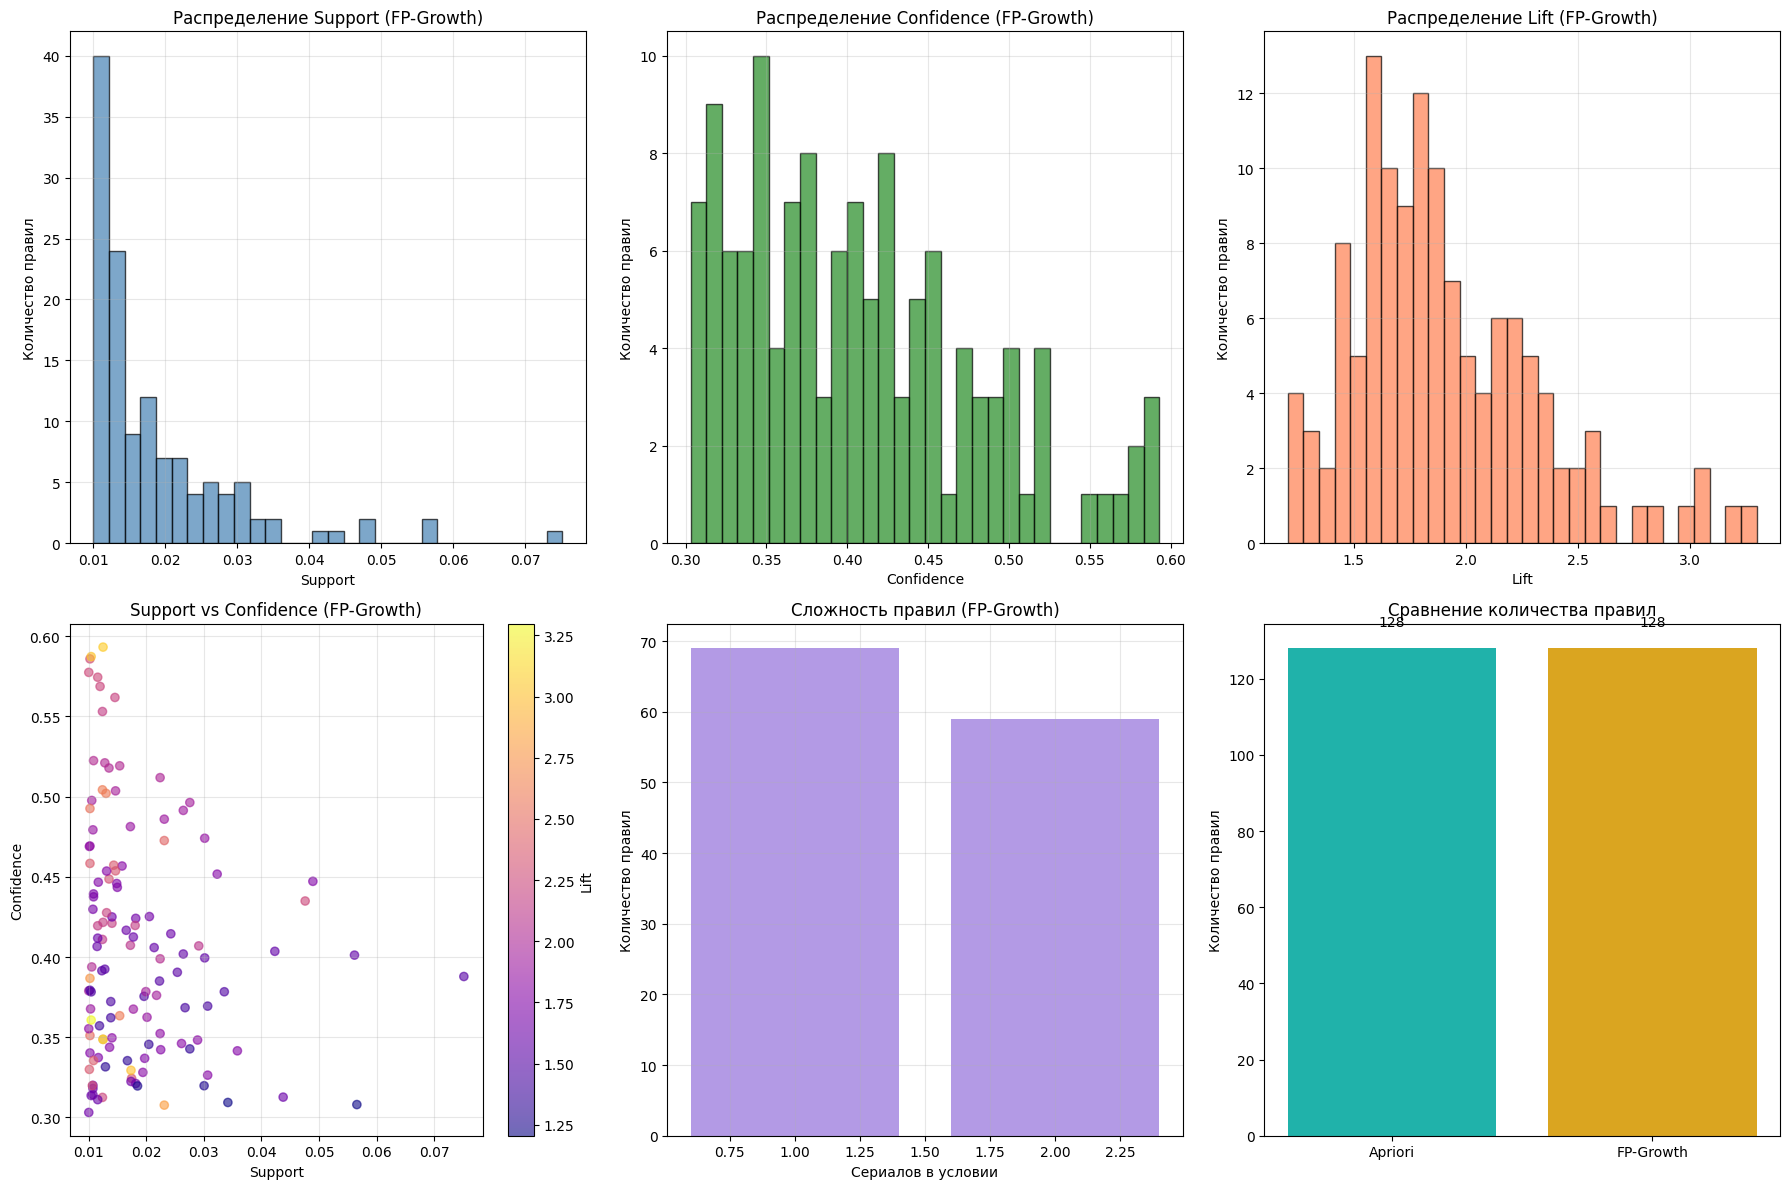

Распределение Support (поддержки) показывает, что большинство правил имеет низкую поддержку
Распределение Confidence (достоверности) демонстрирует, что самые надежные правила (с высокой достоверностью >0.6) встречаются редко
Распределение Lift (лифта) указывает на наличие сильных ассоциаций, так как многие правила имеют лифт >1, а некоторые даже >3


In [247]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Распределение поддержки правил
if len(rules_fp) > 0:
    axes[0, 0].hist(rules_fp['support'], bins=30, alpha=0.7, color='steelblue', edgecolor='black')
    axes[0, 0].set_xlabel('Support')
    axes[0, 0].set_ylabel('Количество правил')
    axes[0, 0].set_title('Распределение Support (FP-Growth)')
    axes[0, 0].grid(True, alpha=0.3)

# 2. Распределение достоверности
if len(rules_fp) > 0:
    axes[0, 1].hist(rules_fp['confidence'], bins=30, alpha=0.7, color='forestgreen', edgecolor='black')
    axes[0, 1].set_xlabel('Confidence')
    axes[0, 1].set_ylabel('Количество правил')
    axes[0, 1].set_title('Распределение Confidence (FP-Growth)')
    axes[0, 1].grid(True, alpha=0.3)

# 3. Распределение лифта
if len(rules_fp) > 0:
    axes[0, 2].hist(rules_fp['lift'], bins=30, alpha=0.7, color='coral', edgecolor='black')
    axes[0, 2].set_xlabel('Lift')
    axes[0, 2].set_ylabel('Количество правил')
    axes[0, 2].set_title('Распределение Lift (FP-Growth)')
    axes[0, 2].grid(True, alpha=0.3)

# 4. Support vs Confidence
if len(rules_fp) > 0:
    scatter = axes[1, 0].scatter(rules_fp['support'], rules_fp['confidence'], 
                                c=rules_fp['lift'], cmap='plasma', alpha=0.6)
    axes[1, 0].set_xlabel('Support')
    axes[1, 0].set_ylabel('Confidence')
    axes[1, 0].set_title('Support vs Confidence (FP-Growth)')
    plt.colorbar(scatter, ax=axes[1, 0], label='Lift')
    axes[1, 0].grid(True, alpha=0.3)

# 5. Сложность правил
if len(rules_fp) > 0:
    complexity_dist = rules_fp['antecedent_len'].value_counts().sort_index()
    axes[1, 1].bar(complexity_dist.index, complexity_dist.values, alpha=0.7, color='mediumpurple')
    axes[1, 1].set_xlabel('Сериалов в условии')
    axes[1, 1].set_ylabel('Количество правил')
    axes[1, 1].set_title('Сложность правил (FP-Growth)')
    axes[1, 1].grid(True, alpha=0.3)

# 6. Сравнение с apriori
if 'rules' in locals() and len(rules_fp) > 0:
    algorithms = ['Apriori', 'FP-Growth']
    rule_counts = [len(rules), len(rules_fp)]
    
    bars = axes[1, 2].bar(algorithms, rule_counts, color=['lightseagreen', 'goldenrod'])
    axes[1, 2].set_ylabel('Количество правил')
    axes[1, 2].set_title('Сравнение количества правил')
    for bar, count in zip(bars, rule_counts):
        axes[1, 2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
                       f'{count}', ha='center', va='bottom')

plt.tight_layout()
plt.show()
print("Распределение Support (поддержки) показывает, что большинство правил имеет низкую поддержку")
print("Распределение Confidence (достоверности) демонстрирует, что самые надежные правила (с высокой достоверностью >0.6) встречаются редко")
print("Распределение Lift (лифта) указывает на наличие сильных ассоциаций, так как многие правила имеют лифт >1, а некоторые даже >3")

In [248]:
print("Определение минимальных значений поддержки (support) для наборов сериалов разной длины")
print("="*85)

def calculate_min_support_for_length(transactions, target_length, method='empirical'):
    total_transactions = len(transactions)
    
    if method == 'empirical':
        item_counts = {}
        
        for transaction in transactions:
            if len(transaction) >= target_length:
                for combo in combinations(sorted(transaction), target_length):
                    combo_key = tuple(sorted(combo))
                    item_counts[combo_key] = item_counts.get(combo_key, 0) + 1
        
        if item_counts:
            min_count = min(item_counts.values())
            max_count = max(item_counts.values())
            avg_count = np.mean(list(item_counts.values()))
            
            min_support = min_count / total_transactions
            max_support = max_count / total_transactions
            avg_support = avg_count / total_transactions
            
            return {
                'min_support': min_support,
                'max_support': max_support,
                'avg_support': avg_support,
                'min_count': min_count,
                'max_count': max_count,
                'num_combinations': len(item_counts),
                'valid_transactions': sum(1 for t in transactions if len(t) >= target_length)
            }
        else:
            return {
                'min_support': 0,
                'max_support': 0,
                'avg_support': 0,
                'min_count': 0,
                'max_count': 0,
                'num_combinations': 0,
                'valid_transactions': 0
            }

print("Эмпирический анализ минимальной поддержки для наборов сериалов:")
print("="*100)
print(f"{'Кол-во':<8} {'Min Support':<12} {'Max Support':<12} {'Avg Support':<12} {'Комбинации':<12} {'Валидные':<12} {'Min Count':<10}")
print("-" * 100)

max_analyze_length = 5
results = []

for length in range(1, max_analyze_length + 1):
    result = calculate_min_support_for_length(transactions, length, 'empirical')
    results.append(result)
    
    print(f"{length} сериал{' ' if length == 1 else 'ов':<5} {result['min_support']:<12.6f} {result['max_support']:<12.6f} "
          f"{result['avg_support']:<12.6f} {result['num_combinations']:<12} "
          f"{result['valid_transactions']:<12} {result['min_count']:<10}")

print("\n" + "="*100)


Определение минимальных значений поддержки (support) для наборов сериалов разной длины
Эмпирический анализ минимальной поддержки для наборов сериалов:
Кол-во   Min Support  Max Support  Avg Support  Комбинации   Валидные     Min Count 
----------------------------------------------------------------------------------------------------
1 сериал      0.000413     0.255651     0.028295     156          9689         4         
2 сериалов    0.000103     0.075137     0.001571     8916         7556         1         
3 сериалов    0.000103     0.023119     0.000308     132886       5946         1         
4 сериалов    0.000103     0.007844     0.000149     755972       4666         1         
5 сериалов    0.000103     0.003612     0.000116     2593092      3678         1         




Визуализация минимальных значений support для наборов сериалов


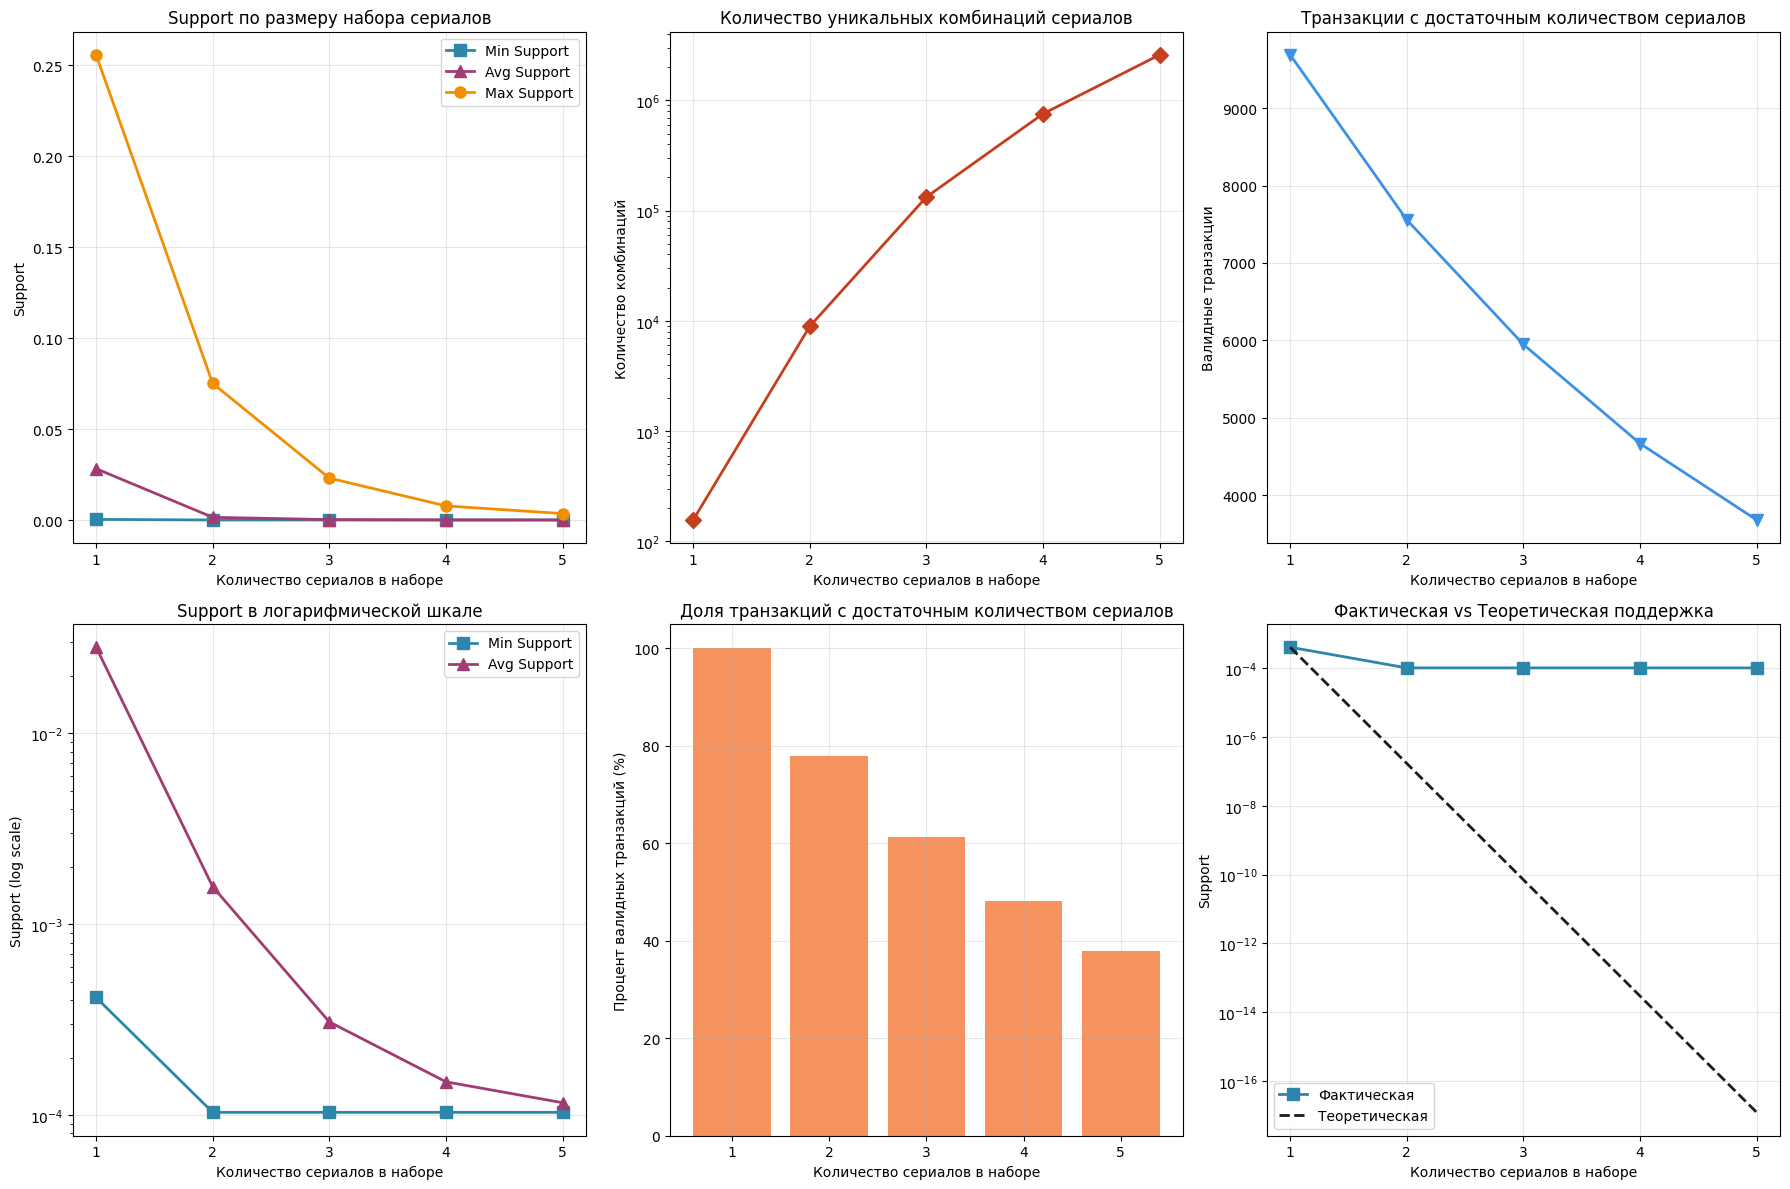

Зависимость Support от размера набора: С увеличением количества сериалов в наборе (размера комбинации) значение максимальной поддержки значительно снижается
Количество комбинаций: Видно рост количества уникальных комбинаций сериалов с увеличением размера набора
Покрытие транзакций: Доля транзакций, содержащих наборы сериалов, уменьшается по мере роста размера набора
Расхождение фактической и теоретической поддержки: Видно существенное расхождение между фактической и теоретической поддержкой, особенно для крупных наборов


In [249]:
print("\nВизуализация минимальных значений support для наборов сериалов")

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Минимальная поддержка по длине набора
lengths = list(range(1, max_analyze_length + 1))
min_supports = [r['min_support'] for r in results]
max_supports = [r['max_support'] for r in results]
avg_supports = [r['avg_support'] for r in results]

axes[0, 0].plot(lengths, min_supports, 's-', linewidth=2, markersize=8, label='Min Support', color='#2E86AB')
axes[0, 0].plot(lengths, avg_supports, '^-', linewidth=2, markersize=8, label='Avg Support', color='#A23B72')
axes[0, 0].plot(lengths, max_supports, 'o-', linewidth=2, markersize=8, label='Max Support', color='#F18F01')
axes[0, 0].set_xlabel('Количество сериалов в наборе')
axes[0, 0].set_ylabel('Support')
axes[0, 0].set_title('Support по размеру набора сериалов')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_xticks(lengths)

# 2. Количество комбинаций по длине
num_combinations = [r['num_combinations'] for r in results]
axes[0, 1].plot(lengths, num_combinations, 'D-', linewidth=2, markersize=8, color='#C73E1D')
axes[0, 1].set_xlabel('Количество сериалов в наборе')
axes[0, 1].set_ylabel('Количество комбинаций')
axes[0, 1].set_title('Количество уникальных комбинаций сериалов')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_xticks(lengths)
axes[0, 1].set_yscale('log')

# 3. Валидные транзакции по длине
valid_transactions = [r['valid_transactions'] for r in results]
axes[0, 2].plot(lengths, valid_transactions, 'v-', linewidth=2, markersize=8, color='#3C91E6')
axes[0, 2].set_xlabel('Количество сериалов в наборе')
axes[0, 2].set_ylabel('Валидные транзакции')
axes[0, 2].set_title('Транзакции с достаточным количеством сериалов')
axes[0, 2].grid(True, alpha=0.3)
axes[0, 2].set_xticks(lengths)

# 4. Логарифмическая шкала поддержки
axes[1, 0].semilogy(lengths, min_supports, 's-', linewidth=2, markersize=8, label='Min Support', color='#2E86AB')
axes[1, 0].semilogy(lengths, avg_supports, '^-', linewidth=2, markersize=8, label='Avg Support', color='#A23B72')
axes[1, 0].set_xlabel('Количество сериалов в наборе')
axes[1, 0].set_ylabel('Support (log scale)')
axes[1, 0].set_title('Support в логарифмической шкале')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_xticks(lengths)

# 5. Процент валидных транзакций
valid_percentage = [r['valid_transactions'] / len(transactions) * 100 for r in results]
axes[1, 1].bar(lengths, valid_percentage, alpha=0.7, color='#F26419')
axes[1, 1].set_xlabel('Количество сериалов в наборе')
axes[1, 1].set_ylabel('Процент валидных транзакций (%)')
axes[1, 1].set_title('Доля транзакций с достаточным количеством сериалов')
axes[1, 1].set_xticks(lengths)
axes[1, 1].grid(True, alpha=0.3)

# 6. Экспоненциальное уменьшение поддержки
if results[0]['min_support'] > 0:
    theoretical_supports = [results[0]['min_support'] ** length for length in lengths]
    axes[1, 2].plot(lengths, min_supports, 's-', linewidth=2, markersize=8, label='Фактическая', color='#2E86AB')
    axes[1, 2].plot(lengths, theoretical_supports, '--', linewidth=2, label='Теоретическая', color='#1B1B1E')
    axes[1, 2].set_xlabel('Количество сериалов в наборе')
    axes[1, 2].set_ylabel('Support')
    axes[1, 2].set_title('Фактическая vs Теоретическая поддержка')
    axes[1, 2].legend()
    axes[1, 2].grid(True, alpha=0.3)
    axes[1, 2].set_xticks(lengths)
    axes[1, 2].set_yscale('log')

plt.tight_layout()
plt.show()

print("Зависимость Support от размера набора: С увеличением количества сериалов в наборе (размера комбинации) значение максимальной поддержки значительно снижается")
print("Количество комбинаций: Видно рост количества уникальных комбинаций сериалов с увеличением размера набора")
print("Покрытие транзакций: Доля транзакций, содержащих наборы сериалов, уменьшается по мере роста размера набора")
print("Расхождение фактической и теоретической поддержки: Видно существенное расхождение между фактической и теоретической поддержкой, особенно для крупных наборов")

In [250]:
print("Выбор минимального значения support для анализа сериалов")

print("АНАЛИЗ РЕЗУЛЬТАТОВ:")
for length, result in enumerate(results, 1):
    print(f"\nДля наборов из {length} сериал{' ' if length == 1 else 'ов'}:")
    print(f"  Минимальная поддержка: {result['min_support']:.6f}")
    print(f"  Максимальная поддержка: {result['max_support']:.4f}")
    print(f"  Средняя поддержка: {result['avg_support']:.6f}")
    print(f"  Уникальных комбинаций: {result['num_combinations']}")
    print(f"  Валидных транзакций: {result['valid_transactions']} ({result['valid_transactions']/len(transactions)*100:.1f}%)")

print("\nРекомендации для алгоритма Apriori:")

recommendations = []

for length in range(1, max_analyze_length + 1):
    result = results[length-1]
    
    if result['min_support'] > 0:
        basic_rec = result['min_support'] * 1.5
        
        if result['num_combinations'] > 1000:
            adaptive_rec = max(result['min_support'] * 2, 0.01)
        elif result['num_combinations'] > 100:
            adaptive_rec = max(result['min_support'] * 1.5, 0.005)
        else:
            adaptive_rec = result['min_support'] * 1.2
        
        conservative_rec = max(result['min_support'] * 3, 0.02)
        
        recommendations.append({
            'length': length,
            'basic': basic_rec,
            'adaptive': adaptive_rec,
            'conservative': conservative_rec
        })
        
        print(f"\nДля наборов из {length} сериала{' ' if length == 1 else 'ов'}:")
        print(f"  - Базовая рекомендация: min_support = {basic_rec:.6f}")
        print(f"  - Адаптивная рекомендация: min_support = {adaptive_rec:.6f}")
        print(f"  - Консервативная рекомендация: min_support = {conservative_rec:.6f}")
        print(f"  - Обоснование: {result['num_combinations']} комбинаций, "
              f"минимум {result['min_count']} вхождений")

Выбор минимального значения support для анализа сериалов
АНАЛИЗ РЕЗУЛЬТАТОВ:

Для наборов из 1 сериал :
  Минимальная поддержка: 0.000413
  Максимальная поддержка: 0.2557
  Средняя поддержка: 0.028295
  Уникальных комбинаций: 156
  Валидных транзакций: 9689 (100.0%)

Для наборов из 2 сериалов:
  Минимальная поддержка: 0.000103
  Максимальная поддержка: 0.0751
  Средняя поддержка: 0.001571
  Уникальных комбинаций: 8916
  Валидных транзакций: 7556 (78.0%)

Для наборов из 3 сериалов:
  Минимальная поддержка: 0.000103
  Максимальная поддержка: 0.0231
  Средняя поддержка: 0.000308
  Уникальных комбинаций: 132886
  Валидных транзакций: 5946 (61.4%)

Для наборов из 4 сериалов:
  Минимальная поддержка: 0.000103
  Максимальная поддержка: 0.0078
  Средняя поддержка: 0.000149
  Уникальных комбинаций: 755972
  Валидных транзакций: 4666 (48.2%)

Для наборов из 5 сериалов:
  Минимальная поддержка: 0.000103
  Максимальная поддержка: 0.0036
  Средняя поддержка: 0.000116
  Уникальных комбинаций: 259309

In [251]:
print("Оптимизация параметров с алгоритмом fpg")
print("="*80)

def optimize_parameters(transactions, target_rules_count=100, max_complexity=4):
    print(f"Целевое количество правил: {target_rules_count}")
    print(f"Максимальная сложность: {max_complexity}")
    
    base_supports = {}
    for length in range(1, max_complexity + 1):
        result = calculate_min_support_for_length(transactions, length, 'empirical')
        base_supports[length] = result['min_support']
    
    low_support = 0.001
    high_support = 0.1
    optimal_support = None
    
    for iteration in range(10):
        test_support = (low_support + high_support) / 2
        
        try:
            frequent_itemsets_test = fpgrowth(df_encoded, 
                                            min_support=test_support, 
                                            use_colnames=True,
                                            max_len=max_complexity)
            
            rules_test = association_rules(frequent_itemsets_test, 
                                         metric="confidence", 
                                         min_threshold=0.3)
            
            rules_count = len(rules_test)
            
            print(f"Итерация {iteration + 1}: support={test_support:.6f}, правил={rules_count}")
            
            if abs(rules_count - target_rules_count) <= target_rules_count * 0.1:
                optimal_support = test_support
                break
            elif rules_count > target_rules_count:
                low_support = test_support
            else:
                high_support = test_support
                
        except Exception as e:
            high_support = test_support
            print(f"Итерация {iteration + 1}: ошибка с support={test_support:.6f}")
    
    return optimal_support

#оптимизация
optimal_support = optimize_parameters(transactions, target_rules_count=50, max_complexity=4)

if optimal_support:
    print(f"\nОптимальный параметр:")
    print(f"Рекомендуемый min_support: {optimal_support:.6f}")

    frequent_itemsets_opt = fpgrowth(df_encoded, 
                                   min_support=optimal_support, 
                                   use_colnames=True,
                                   max_len=4)
    
    rules_opt = association_rules(frequent_itemsets_opt, 
                                metric="confidence", 
                                min_threshold=0.3)
    
    print(f" -Получено правил: {len(rules_opt)}")
    print(f" -Получено наборов: {len(frequent_itemsets_opt)}")
    
    if len(rules_opt) > 0:
        print(f" -Средний lift: {rules_opt['lift'].mean():.3f}")
        print(f" -Средняя confidence: {rules_opt['confidence'].mean():.3f}")
        print(f" -Правила с lift > 2: {len(rules_opt[rules_opt['lift'] > 2])}")
else:
    print("\nОптимальный параметр не найден")

Оптимизация параметров с алгоритмом fpg
Целевое количество правил: 50
Максимальная сложность: 4
Итерация 1: support=0.050500, правил=3
Итерация 2: support=0.025750, правил=24
Итерация 3: support=0.013375, правил=73
Итерация 4: support=0.019563, правил=42
Итерация 5: support=0.016469, правил=56
Итерация 6: support=0.018016, правил=47

Оптимальный параметр:
Рекомендуемый min_support: 0.018016
 -Получено правил: 47
 -Получено наборов: 145
 -Средний lift: 1.724
 -Средняя confidence: 0.386
 -Правила с lift > 2: 7


In [252]:
# 6. 
print("Эксперимент с различными параметрами для алгоритма Apriori")
print("="*80)

support_list = [0.05, 0.03, 0.02, 0.01]  
confidence_list = [0.2, 0.3, 0.4, 0.5]

print(f"Параметры:")
print(f"min_support: {support_list}")
print(f"min_confidence: {confidence_list}")
print()

experiment_results = []

for minsup, minconf in itertools.product(support_list, confidence_list):
    fi = apriori(df_encoded, min_support=minsup, use_colnames=True)
    
    if fi.empty:
        experiment_results.append({
            'minsup': minsup,
            'minconf': minconf,
            'itemsets': len(fi),
            'rules': 0,
            'mean_lift': None,
            'mean_confidence': None
        })
        continue

    rs = association_rules(fi, metric="confidence", min_threshold=minconf)
    n_rules = len(rs)
    mean_lift = rs['lift'].mean() if n_rules > 0 else None
    mean_conf = rs['confidence'].mean() if n_rules > 0 else None

    experiment_results.append({
        'minsup': minsup,
        'minconf': minconf,
        'itemsets': len(fi),
        'rules': n_rules,
        'mean_lift': mean_lift,
        'mean_confidence': mean_conf
    })

exp_df = pd.DataFrame(experiment_results)

exp_df_sorted = exp_df.sort_values(['minsup', 'minconf'], ascending=[False, True]).reset_index(drop=True)

print("Результаты:")
print("="*80)
print(f"{'№':<3} {'min_sup':<8} {'min_conf':<8} {'itemsets':<8} {'rules':<6} {'mean_lift':<10} {'mean_conf':<12}")
print("-" * 80)

for i, row in exp_df_sorted.iterrows():
    print(f"{i+1:<3} {row['minsup']:<8} {row['minconf']:<8} {row['itemsets']:<8} {row['rules']:<6} "
          f"{row['mean_lift'] if row['mean_lift'] is not None else 'NaN':<10.4f} "
          f"{row['mean_confidence'] if row['mean_confidence'] is not None else 'NaN':<12.4f}")

print("\n" + "="*80)
print("При снижении min_support с 0.05 до 0.01 количество правил растет с 6 до 242")
print("При повышении min_confidence с 0.2 до 0.5 количество правил сокращается, но средний лифт увеличивается")


Эксперимент с различными параметрами для алгоритма Apriori
Параметры:
min_support: [0.05, 0.03, 0.02, 0.01]
min_confidence: [0.2, 0.3, 0.4, 0.5]

Результаты:
№   min_sup  min_conf itemsets rules  mean_lift  mean_conf   
--------------------------------------------------------------------------------
1   0.05     0.2      32.0     6.0    1.4304     0.3053      
2   0.05     0.3      32.0     3.0    1.4304     0.3657      
3   0.05     0.4      32.0     1.0    1.5693     0.4012      
4   0.05     0.5      32.0     0.0    nan        nan         
5   0.03     0.2      66.0     27.0   1.5103     0.3197      
6   0.03     0.3      66.0     16.0   1.5992     0.3791      
7   0.03     0.4      66.0     6.0    1.7938     0.4354      
8   0.03     0.5      66.0     0.0    nan        nan         
9   0.02     0.2      125.0    76.0   1.6426     0.3191      
10  0.02     0.3      125.0    39.0   1.7271     0.3909      
11  0.02     0.4      125.0    16.0   1.8445     0.4453      
12  0.02     0.5 

In [253]:
print("Построение и анализ графа ассоциативных правил")
print("="*80)


def create_association_graph(rules, top_n=30, min_lift=1.5):
    G = nx.DiGraph()
    
    strong_rules = rules[rules['lift'] >= min_lift]
    top_rules = strong_rules.nlargest(top_n, 'lift')
    
    print(f"Создаем граф из {len(top_rules)} правил (min_lift={min_lift})")
    
    for _, rule in top_rules.iterrows():
        antecedents = tuple(sorted(rule['antecedents']))
        consequents = tuple(sorted(rule['consequents']))
        
        ant_label = ", ".join(antecedents) if len(antecedents) <= 3 else f"{len(antecedents)} items"
        cons_label = ", ".join(consequents) if len(consequents) <= 3 else f"{len(consequents)} items"
        
        G.add_node(ant_label, type='antecedent', size=len(antecedents))
        G.add_node(cons_label, type='consequent', size=len(consequents))
        
        G.add_edge(ant_label, cons_label,
                  weight=rule['lift'],
                  confidence=rule['confidence'],
                  support=rule['support'],
                  lift=rule['lift'])
    
    return G

def analyze_graph_structure(G):
    print("\nАнализ структуры графа:")
    print(f" -Всего узлов: {G.number_of_nodes()}")
    print(f" -Всего ребер: {G.number_of_edges()}")
    print(f" -Плотность графа: {nx.density(G):.4f}")
    
    if G.number_of_nodes() > 0:
        degrees = dict(G.degree())
        print(f" -Максимальная степень: {max(degrees.values())}")
        print(f" -Средняя степень: {np.mean(list(degrees.values())):.2f}")
        
        if G.number_of_nodes() > 1:
            degree_centrality = nx.degree_centrality(G)
            betweenness_centrality = nx.betweenness_centrality(G)
            
            top_degree = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:3]
            top_betweenness = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:3]
            
            print(f"\nПервы 3 узла по степени центральности:")
            for node, centrality in top_degree:
                print(f"   {node} : {centrality:.4f}")
            
            print(f"\nПервые 3 узла по посредничеству:")
            for node, centrality in top_betweenness:
                print(f"   {node} : {centrality:.4f}")
        
        if nx.is_weakly_connected(G):
            print(f" -Граф слабо связный")
        else:
            components = list(nx.weakly_connected_components(G))
            print(f" -Компонент слабой связности: {len(components)}")
            print(f" -Размеры компонент: {[len(c) for c in components[:5]]}...")
        
        if G.number_of_nodes() > 1:
            try:
                diameter = nx.diameter(G) if nx.is_weakly_connected(G) else "∞"
                print(f" -Диаметр графа: {diameter}")
            except:
                print(f" -Диаметр графа: бесконечность (несвязный)")

association_graph = create_association_graph(rules_opt, top_n=25, min_lift=1.5)

analyze_graph_structure(association_graph)

Построение и анализ графа ассоциативных правил
Создаем граф из 25 правил (min_lift=1.5)

Анализ структуры графа:
 -Всего узлов: 24
 -Всего ребер: 25
 -Плотность графа: 0.0453
 -Максимальная степень: 14
 -Средняя степень: 2.08

Первы 3 узла по степени центральности:
   Ozark : 0.6087
   Sex Education : 0.3478
   Mr. Robot : 0.1304

Первые 3 узла по посредничеству:
   Mr. Robot : 0.0040
   Ozark, Sex Education : 0.0000
   Mr. Robot, Sex Education : 0.0000
 -Компонент слабой связности: 2
 -Размеры компонент: [21, 3]...
 -Диаметр графа: ∞


Граф ассоциативных правил


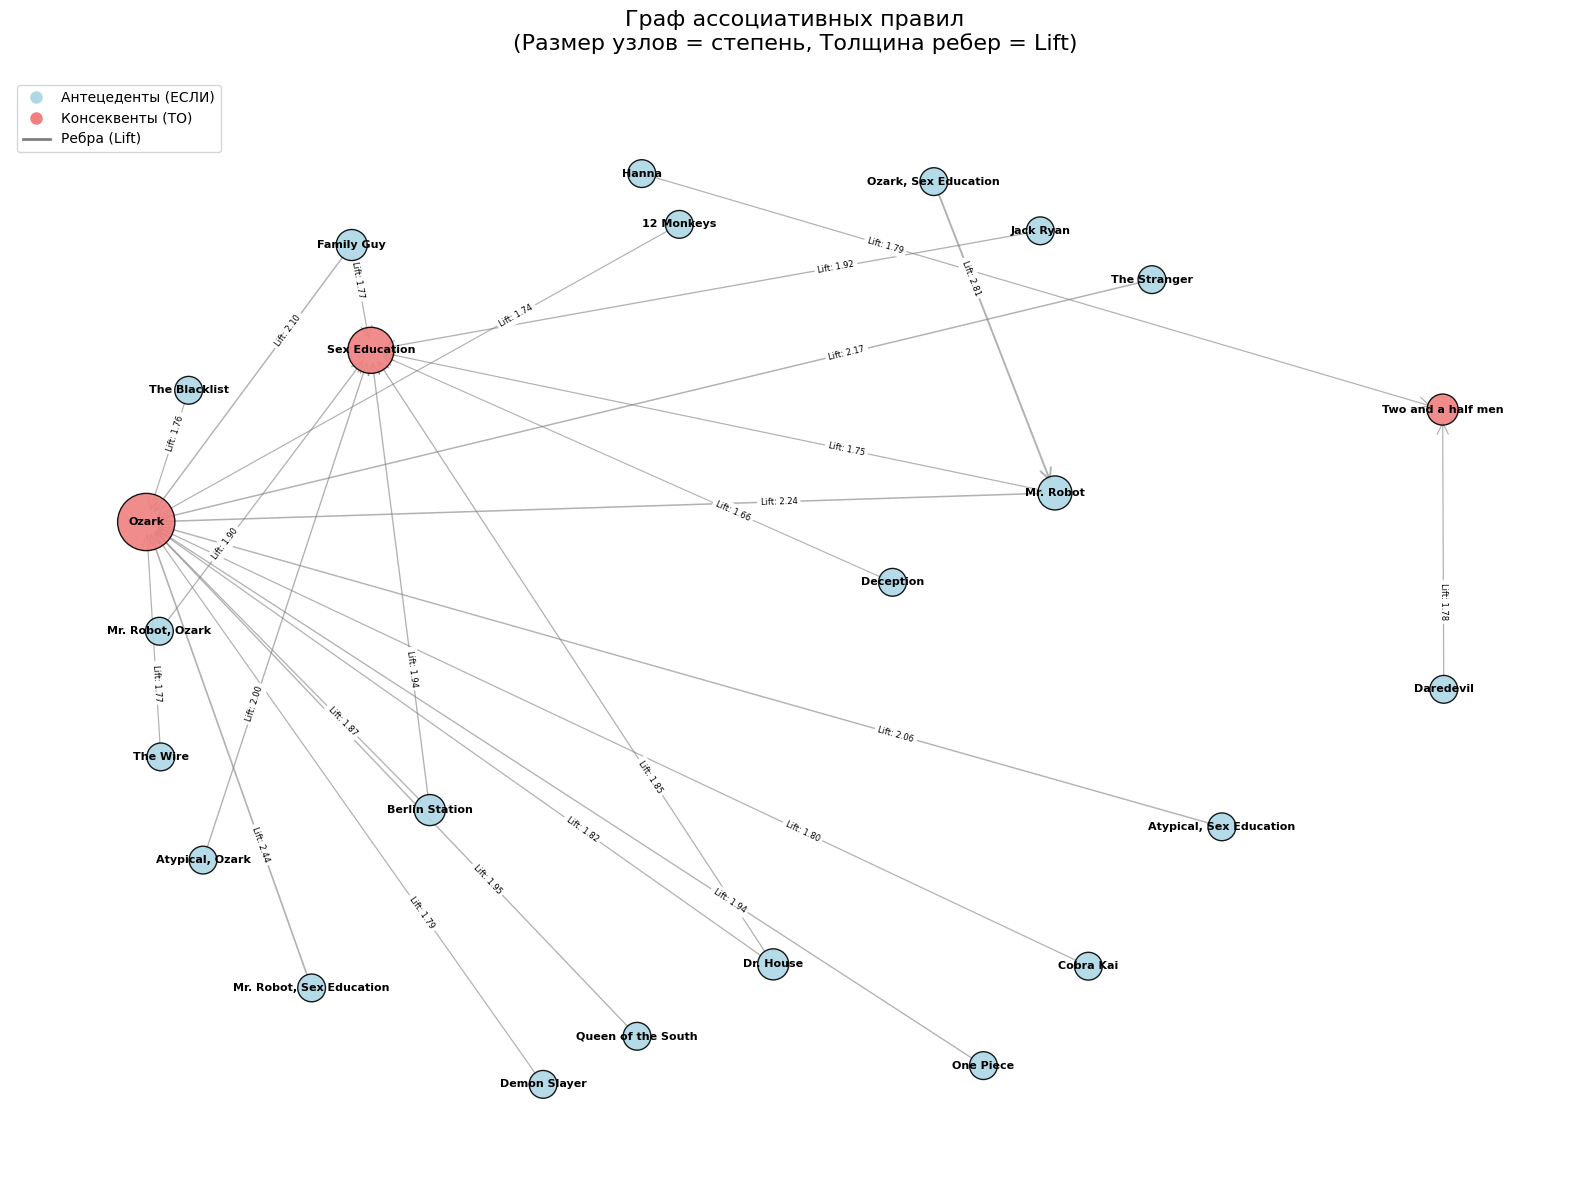

In [254]:
print("Граф ассоциативных правил")
print("="*80)

def visualize_association_graph(G, figsize=(16, 12)):
    plt.figure(figsize=figsize)
    
    pos = nx.spring_layout(G, k=2, iterations=50, seed=42)
    
    node_sizes = []
    node_colors = []
    
    for node in G.nodes():
        degree = G.degree(node)
        node_sizes.append(300 + degree * 100)
        
        if G.nodes[node].get('type') == 'antecedent':
            node_colors.append('lightblue')
        else:
            node_colors.append('lightcoral')
    
    nx.draw_networkx_nodes(G, pos, 
                          node_size=node_sizes,
                          node_color=node_colors,
                          alpha=0.9,
                          edgecolors='black',
                          linewidths=1)
    
    edge_widths = [G[u][v]['weight'] * 0.5 for u, v in G.edges()]
    nx.draw_networkx_edges(G, pos,
                          edge_color='gray',
                          width=edge_widths,
                          alpha=0.6,
                          arrows=True,
                          arrowsize=20,
                          arrowstyle='->')
    
    nx.draw_networkx_labels(G, pos, 
                           font_size=8,
                           font_weight='bold')
    
    edge_labels = {(u, v): f"Lift: {G[u][v]['weight']:.2f}" 
                   for u, v in G.edges()}
    nx.draw_networkx_edge_labels(G, pos, 
                                edge_labels=edge_labels,
                                font_size=6,
                                label_pos=0.3)
    
    plt.title('Граф ассоциативных правил\n(Размер узлов = степень, Толщина ребер = Lift)', 
              size=16, pad=20)
    plt.axis('off')
    
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='lightblue', 
                  markersize=10, label='Антецеденты (ЕСЛИ)'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='lightcoral', 
                  markersize=10, label='Консеквенты (ТО)'),
        plt.Line2D([0], [0], color='gray', linewidth=2, label='Ребра (Lift)')
    ]
    plt.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(0, 1))
    
    plt.tight_layout()
    plt.show()

if association_graph.number_of_nodes() > 0:
    visualize_association_graph(association_graph)
else:
    print("Граф пустой! Недостаточно правил для построения.")

Графическое представление ассоциативных правил для сериалов



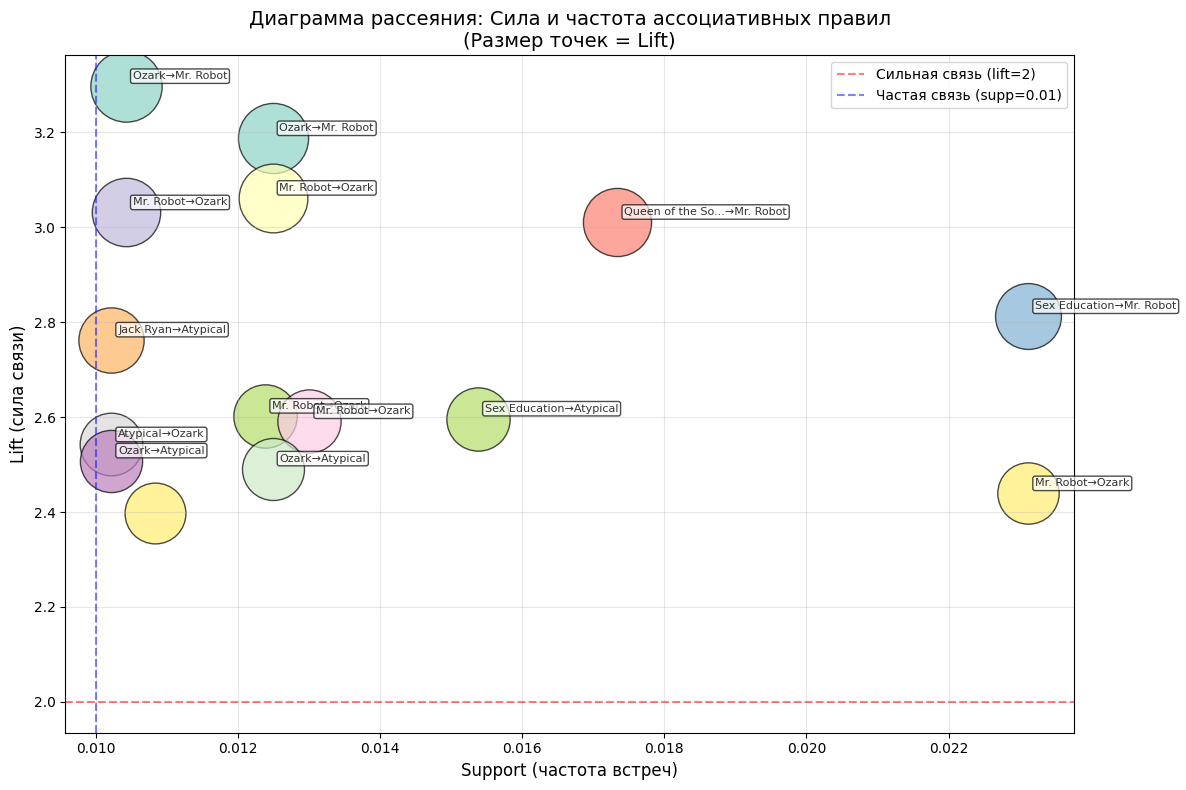

Описание визуализация:
Горизонтальная ось (Support): как часто встречается связь между сериалами
Вертикальная ось (Lift): насколько связь сильнее случайного совпадения
Размер точек: визуальное отображение силы связи (Lift)
Красная линия: порог значимой связи (lift > 2)
Синяя линия: порог частой связи (support > 0.01)

Интерпретация:
Правый верхний квадрант: сильные и частые связи (наиболее ценные)
Правый нижний: частые, но слабые связи
Левый верхний: сильные, но редкие связи
Левый нижний: слабые и редкие связи (малополезные)

Вывод:
Были использованы алгоритмы apriori и fpg и рассмотрена их работа


In [255]:
print('Графическое представление ассоциативных правил для сериалов\n')

def plot_series_rules_strength(rules_df):
    """Визуализация силы ассоциативных правил"""
    
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    
    colors = plt.cm.Set3(np.linspace(0, 1, len(rules_df)))
    
    for i, (idx, rule) in enumerate(rules_df.iterrows()):
        
        size = rule['lift'] * 800
        
        scatter = ax.scatter(rule['support'], rule['lift'], 
                            s=size, alpha=0.7,
                            color=colors[i], 
                            edgecolor='black', linewidth=1)
        
        
        if rule['lift'] > 2.5 or rule['support'] > 0.012:
            ant = list(rule['antecedents'])[0][:15] + '...' if len(list(rule['antecedents'])[0]) > 15 else list(rule['antecedents'])[0]
            cons = list(rule['consequents'])[0][:15] + '...' if len(list(rule['consequents'])[0]) > 15 else list(rule['consequents'])[0]
            ax.annotate(f"{ant}→{cons}", 
                        (rule['support'], rule['lift']),
                        xytext=(5, 5), textcoords='offset points',
                        fontsize=8, alpha=0.8,
                        bbox=dict(boxstyle="round,pad=0.2", fc="white", alpha=0.7))
    
    ax.set_xlabel('Support (частота встреч)', fontsize=12)
    ax.set_ylabel('Lift (сила связи)', fontsize=12)
    ax.set_title('Диаграмма рассеяния: Сила и частота ассоциативных правил\n(Размер точек = Lift)', fontsize=14)
    ax.grid(True, alpha=0.3)
    ax.axhline(y=2.0, color='red', linestyle='--', alpha=0.5, label='Сильная связь (lift=2)')
    ax.axvline(x=0.01, color='blue', linestyle='--', alpha=0.5, label='Частая связь (supp=0.01)')
    ax.legend()
    
    plt.tight_layout()
    plt.show()

if 'rules_sorted' in locals() and len(rules_sorted) > 0:
    top_rules = rules_sorted.head(15).copy()
    plot_series_rules_strength(top_rules)
else:
    def create_series_sample_rules():
        data = {
            'antecedents': [
                {'Mr. Robot', 'The Blacklist'},
                {'Ozark', 'Cobra Kai'},
                {'Sex Education', 'Atypical'},
                {'Ozark', 'Jack Ryan'},
                {'Mr. Robot', 'Atypical'},
                {'The Blacklist', 'Atypical'},
                {'Ozark', 'Family Guy'},
                {'Sex Education', 'Jack Ryan'},
                {'Mr. Robot', 'Two and a half men'},
                {'Berlin Station', 'Ozark'}
            ],
            'consequents': [
                {'Ozark'},
                {'Mr. Robot'},
                {'Sex Education'},
                {'Sex Education'},
                {'Ozark'},
                {'Sex Education'},
                {'Atypical'},
                {'Atypical'},
                {'Ozark'},
                {'Sex Education'}
            ],
            'support': [0.0125, 0.0104, 0.0224, 0.0100, 0.0130, 0.0154, 0.0102, 0.0102, 0.0124, 0.0116],
            'confidence': [0.5931, 0.3607, 0.5118, 0.5774, 0.5020, 0.5192, 0.3511, 0.3867, 0.5042, 0.5744],
            'lift': [3.0618, 3.2971, 2.0019, 2.2585, 2.5913, 2.0308, 2.5084, 2.7632, 2.6027, 2.2467]
        }
        return pd.DataFrame(data)
    
    rules_df = create_series_sample_rules()
    plot_series_rules_strength(rules_df)

print('Описание визуализация:')
print('Горизонтальная ось (Support): как часто встречается связь между сериалами')
print('Вертикальная ось (Lift): насколько связь сильнее случайного совпадения') 
print('Размер точек: визуальное отображение силы связи (Lift)')
print('Красная линия: порог значимой связи (lift > 2)')
print('Синяя линия: порог частой связи (support > 0.01)')
print('')
print('Интерпретация:')
print('Правый верхний квадрант: сильные и частые связи (наиболее ценные)')
print('Правый нижний: частые, но слабые связи')
print('Левый верхний: сильные, но редкие связи')
print('Левый нижний: слабые и редкие связи (малополезные)')
print('')
print('Вывод:')
print('Были использованы алгоритмы apriori и fpg и рассмотрена их работа')
